<a href="https://colab.research.google.com/github/yousefselim1/NTI_Project_Food-Recognition/blob/main/foodCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using Colab cache for faster access to the 'nutrition5k-dataset' dataset.
DATA_ROOT: /kaggle/input/nutrition5k-dataset
Found 0 image files.
Falling back to pickle-based images…
Displaying 5 images…


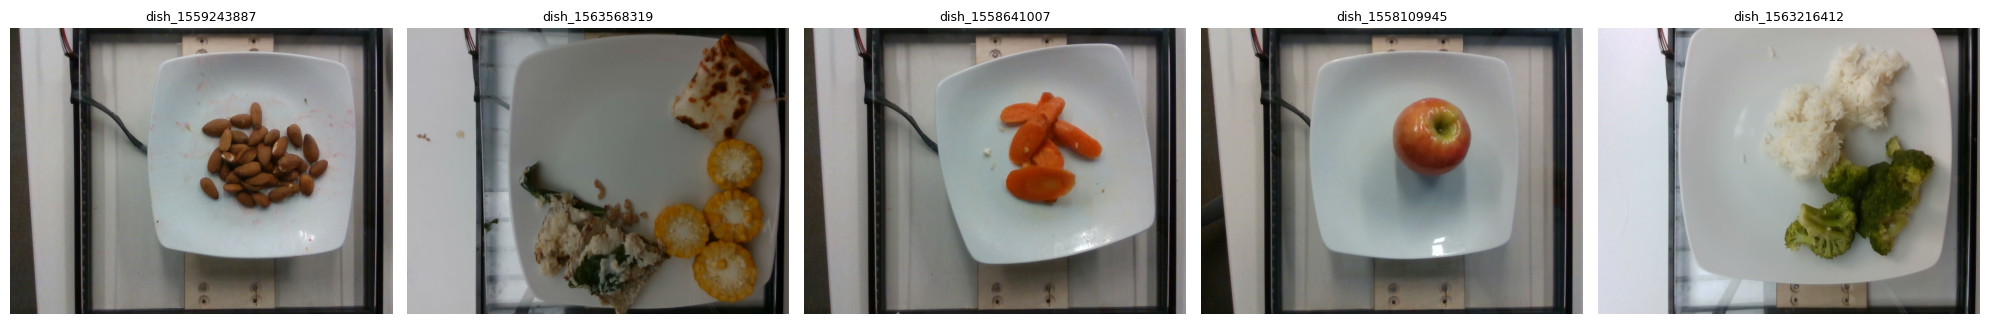

In [1]:
# ==== 0) Install deps (Colab) ====
!pip -q install kagglehub pandas matplotlib pillow

# ==== 1) Download Nutrition5k (Kaggle mirror) ====
import kagglehub, os, io, base64, pickle, glob
from pathlib import Path
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

DATASET = "siddhantrout/nutrition5k-dataset"  # Kaggle mirror
data_root = Path(kagglehub.dataset_download(DATASET))
print("DATA_ROOT:", data_root)

# ==== 2) Try to collect real image files (jpg/png) ====
img_paths = []
for ext in ("*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG"):
    img_paths += list(data_root.rglob(ext))
img_paths = sorted(img_paths)
print(f"Found {len(img_paths)} image files.")

images = []
titles = []

# If we have at least 5 actual image files, use them
if len(img_paths) >= 5:
    for p in img_paths[:5]:
        try:
            img = Image.open(p).convert("RGB")
            images.append(img)
            # try to show a dish id if present in path
            titles.append(p.name[:40])
        except Exception as e:
            print("Skipping:", p, "->", e)

# ==== 3) Fallback: if mirror stores data in a pickle ====
if len(images) < 5:
    print("Falling back to pickle-based images…")
    pkl = next((p for p in data_root.rglob("dish_images.pkl")), None)
    if pkl is None:
        raise FileNotFoundError("No images and no 'dish_images.pkl' found in this mirror.")
    with open(pkl, "rb") as f:
        data = pickle.load(f)

    # Data can be dict/list/DataFrame depending on mirror
    try:
        df = pd.DataFrame(data)
    except Exception:
        df = data  # already DataFrame

    # columns commonly used: 'dish' and 'rgb_image' (bytes or base64)
    cnt = 0
    for _, row in df.iterrows():
        blob = row.get("rgb_image") or row.get("image_bytes")
        if blob is None:
            continue
        if isinstance(blob, str):
            try:
                blob = base64.b64decode(blob)
            except Exception:
                continue
        try:
            img = Image.open(io.BytesIO(blob)).convert("RGB")
            images.append(img)
            titles.append(str(row.get("dish") or row.get("dish_id") or f"img_{cnt}"))
            cnt += 1
            if cnt == 5:
                break
        except Exception:
            continue

if len(images) == 0:
    raise RuntimeError("Could not load any images from this dataset mirror.")

print(f"Displaying {len(images)} images…")

# ==== 4) Show first 5 images ====
n = len(images)
fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
if n == 1:
    axes = [axes]
for ax, img, title in zip(axes, images, titles):
    ax.imshow(img)
    ax.set_title(str(title), fontsize=9)
    ax.axis("off")
plt.tight_layout()
plt.show()

In [2]:
# قِيمَة (Qiima) — Nutrition5k v3 (RGB → Calories & Macros)



import os, re, glob, json, base64, pickle
from pathlib import Path
import requests
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import GroupShuffleSplit

print("TensorFlow:", tf.__version__)


## 1) Configure paths & download


USE_KAGGLEHUB = True
DATASET = "siddhantrout/nutrition5k-dataset"

download_path = None
if USE_KAGGLEHUB:
    try:
        import kagglehub
        download_path = kagglehub.dataset_download(DATASET)
        print("KaggleHub dataset path:", download_path)
    except Exception as e:
        print("KaggleHub download failed:", e)


assert download_path is not None, "Please set `download_path` to your Nutrition5k location."
DATA_ROOT = Path(download_path)
print("DATA_ROOT:", DATA_ROOT)


## 2) Load dish metadata


def download_official_metadata(dst_dir: Path):
    base = "https://raw.githubusercontent.com/google-research-datasets/Nutrition5k/main/res/metadata"
    files = ["dish_metadata_cafe1.csv", "dish_metadata_cafe2.csv", "ingredient_metadata.csv"]
    dst_dir.mkdir(parents=True, exist_ok=True)
    out = {}
    for fname in files:
        url = f"{base}/{fname}"
        r = requests.get(url, timeout=60)
        r.raise_for_status()
        p = dst_dir / fname
        p.write_bytes(r.content)
        out[fname] = p
        print("Downloaded:", p)
    return out

file_candidates = list(DATA_ROOT.rglob("*.csv")) + list(DATA_ROOT.rglob("*.xlsx"))
print("Found CSV/XLSX locally:", len(file_candidates))

chosen = None
priority_names = ["dish_metadata_captured.csv", "metadata.csv", "nutrients.csv", "dishes.xlsx"]
for name in priority_names:
    matches = list(DATA_ROOT.rglob(name))
    if matches:
        chosen = matches[0]; break

if chosen is None and file_candidates:
    chosen = max(file_candidates, key=lambda p: p.stat().st_size)

if chosen is not None:
    print("Using local metadata file:", chosen)
    if str(chosen).endswith(".csv"):
        dish_df = pd.read_csv(chosen)
    elif str(chosen).endswith(".xlsx"):
        dish_df = pd.read_excel(chosen)
    else:
        raise ValueError("Unsupported metadata file type.")
else:
    print("No local dish CSV/XLSX found — downloading official metadata…")
    paths = download_official_metadata(Path("./nutrition5k_meta"))
    dish_df = pd.concat(
        [pd.read_csv(paths["dish_metadata_cafe1.csv"]),
         pd.read_csv(paths["dish_metadata_cafe2.csv"])],
        ignore_index=True
    )

dish_df["dish_id"] = dish_df["dish_id"].astype(str)
rename_map = {
    "total_calories": "kcal",
    "total_carb": "carbs",
    "total_protein": "protein",
    "total_fat": "fat",
    "calories": "kcal",
    "carb": "carbs",
    "protein_g": "protein",
    "fat_g": "fat",
}
for old, new in rename_map.items():
    if old in dish_df.columns and new not in dish_df.columns:
        dish_df.rename(columns={old: new}, inplace=True)

required_cols = {"dish_id","kcal","carbs","protein","fat"}
missing = required_cols - set(dish_df.columns)
if missing:
    raise ValueError(f"Dish metadata missing columns: {missing}. Available: {list(dish_df.columns)[:25]}...")

dish_df = dish_df[["dish_id","kcal","carbs","protein","fat"]].copy()
dish_df.head()


## 3) Map images → dish_id


img_exts = ("*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG")
img_files = []
for ext in img_exts:
    img_files += glob.glob(str(DATA_ROOT / "**" / ext), recursive=True)

def extract_dish_id(p: str):
    m = re.search(r"dish_\d{6,12}", p)
    if m: return m.group(0)
    for part in Path(p).parts:
        if re.match(r"dish_\d{6,12}", part or ""):
            return part
    if re.match(r"dish_\d{6,12}", Path(p).stem):
        return Path(p).stem
    return None

if len(img_files) > 0:
    img_df = pd.DataFrame({"abs_image_path": img_files})
    img_df["dish_id"] = img_df["abs_image_path"].apply(extract_dish_id)
    img_df = img_df.dropna(subset=["dish_id"]).reset_index(drop=True)
    print("Found image files:", len(img_df))
else:
    pkl_path = DATA_ROOT / "dish_images.pkl"
    if not pkl_path.exists():
        raise FileNotFoundError(f"No images found and {pkl_path} not present.")
    print("Falling back to pickle:", pkl_path)
    with open(pkl_path, "rb") as f:
        dish_images_data = pickle.load(f)
    try:
        dish_images_df = pd.DataFrame(dish_images_data)
    except Exception:
        dish_images_df = dish_images_data
    tmp_dir = Path("/tmp/temp_images"); tmp_dir.mkdir(exist_ok=True)
    records = []
    for _, row in dish_images_df.iterrows():
        dish_id = str(row.get("dish") or row.get("dish_id"))
        if not dish_id: continue
        blob = row.get("rgb_image")
        if blob is None: continue
        if isinstance(blob, str):
            try: blob = base64.b64decode(blob)
            except Exception: continue
        if not isinstance(blob, (bytes, bytearray)): continue
        out_path = tmp_dir / f"{dish_id}.jpg"
        try:
            with open(out_path, "wb") as w: w.write(blob)
            records.append({"abs_image_path": str(out_path), "dish_id": dish_id})
        except Exception:
            continue
    img_df = pd.DataFrame(records)
    print("Extracted images from pickle:", len(img_df))

assert len(img_df) > 0, "No usable images found."
df = img_df.merge(dish_df, on="dish_id", how="inner")
print("Usable (image,label) pairs:", len(df))
assert len(df) > 100, "Not enough matches. Check dish_id parsing and metadata."
df.head()


## 4) Grouped Train/Val split


groups = df["dish_id"].values
gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
train_idx, val_idx = next(gss.split(df, groups=groups))
train_df = df.iloc[train_idx].reset_index(drop=True)
val_df   = df.iloc[val_idx].reset_index(drop=True)

print("Train/Val sizes:", len(train_df), len(val_df),
      "| unique dishes val:", val_df["dish_id"].nunique())


## 5) Targets: log1p + standardization


TARGET_COLS = ["kcal","carbs","protein","fat"]

train_log = np.log1p(train_df[TARGET_COLS])
val_log   = np.log1p(val_df[TARGET_COLS])

z_mean = train_log.mean()
z_std  = train_log.std().replace(0, 1)

train_df_norm = train_df.copy()
val_df_norm   = val_df.copy()
train_df_norm[TARGET_COLS] = (train_log - z_mean) / z_std
val_df_norm[TARGET_COLS]   = (val_log   - z_mean) / z_std

def denorm_and_exp(arr):
    z = arr * z_std.values + z_mean.values
    y = np.expm1(z)
    return np.clip(y, 0, None)


## 6) tf.data pipeline (384×384)


try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy("mixed_float16")
    print("Mixed precision enabled.")
except Exception:
    pass

IMG_SIZE = (384, 384)
BATCH = 32
AUTO = tf.data.AUTOTUNE

def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMG_SIZE)
    return img

augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

def ds_from(df, training=True):
    x = df["abs_image_path"].values
    y = df[TARGET_COLS].values.astype("float32")
    ds = tf.data.Dataset.from_tensor_slices((x,y))
    if training: ds = ds.shuffle(len(df), seed=42)
    ds = ds.map(lambda p,t: (load_img(p), t), num_parallel_calls=AUTO)
    if training: ds = ds.map(lambda im,t: (augment(im, training=True), t), num_parallel_calls=AUTO)
    return ds.batch(BATCH).prefetch(AUTO)

train_ds = ds_from(train_df_norm, True)
val_ds   = ds_from(val_df_norm,   False)


## 7) Model: EfficientNet‑B3 + Weighted Huber


base = keras.applications.EfficientNetB3(include_top=False, input_shape=IMG_SIZE + (3,), weights="imagenet")
base.trainable = False

inp = keras.Input(shape=IMG_SIZE + (3,))
x = keras.applications.efficientnet.preprocess_input(inp)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.3)(x)
out = layers.Dense(4, activation="linear", name="nutrients")(x)

model = keras.Model(inp, out, name="qiima_efficientnet_b3_384")

loss_weights = tf.constant([1.5, 2.0, 1.0, 1.0], dtype=tf.float32)  # [kcal, carbs, protein, fat]
def weighted_huber(y_true, y_pred, delta=1.0):
    err = y_true - y_pred
    abs_err = tf.abs(err)
    quad = tf.minimum(abs_err, delta)
    lin = abs_err - quad
    huber = 0.5 * tf.square(quad) + delta * lin
    huber = huber * loss_weights
    return tf.reduce_mean(tf.reduce_sum(huber, axis=-1))

opt = keras.optimizers.Adam(1e-3, clipnorm=1.0)
model.compile(optimizer=opt, loss=weighted_huber)
model.summary()

TensorFlow: 2.19.0
Using Colab cache for faster access to the 'nutrition5k-dataset' dataset.
KaggleHub dataset path: /kaggle/input/nutrition5k-dataset
DATA_ROOT: /kaggle/input/nutrition5k-dataset
Found CSV/XLSX locally: 3
Using local metadata file: /kaggle/input/nutrition5k-dataset/dishes.xlsx
Falling back to pickle: /kaggle/input/nutrition5k-dataset/dish_images.pkl
Extracted images from pickle: 3490
Usable (image,label) pairs: 3490
Train/Val sizes: 2966 524 | unique dishes val: 524
Mixed precision enabled.


Model: "qiima_efficientnet_b3_384"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 384, 384, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 12, 12, 1536)   │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ nutrients (Dense)               │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,572,531 (44.15 MB)

 Trainable params: 788,996 (3.01 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [3]:
# ==== Stage 1: frozen backbone مع subset للتجربة ====
ckpt_dir = Path("checkpoints"); ckpt_dir.mkdir(exist_ok=True, parents=True)
best_ckpt = str(ckpt_dir / "best_stage1_subset.weights.h5")  # اسم مختلف علشان التجربة

callbacks = [
    keras.callbacks.ModelCheckpoint(best_ckpt, monitor="val_loss", mode="min", save_best_only=True, save_weights_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
]

# 1️⃣ إنشاء subset صغير (20%) من بيانات التدريب
subset_train_df = train_df_norm.sample(frac=0.35, random_state=42)
train_ds_subset = ds_from(subset_train_df, training=True)
val_ds_subset   = ds_from(val_df_norm, training=False)


# 2️⃣ تدريب سريع على subset
hist1_subset = model.fit(
    train_ds_subset,
    validation_data=val_ds_subset,
    epochs=8,  # تجربة سريعة
    callbacks=callbacks
)


Epoch 1/8
33/33 ━━━━━━━━━━━━━━━━━━━━ 292s 6s/step - loss: 3.1901 - val_loss: 2.4925
Epoch 2/8
33/33 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - loss: 2.4660 - val_loss: 2.4046
Epoch 3/8
33/33 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - loss: 2.4699 - val_loss: 2.4061
Epoch 4/8
33/33 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - loss: 2.4449 - val_loss: 2.4026
Epoch 5/8
33/33 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 2.3057 - val_loss: 2.4242
Epoch 6/8
33/33 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - loss: 2.4703 - val_loss: 2.4211
Epoch 7/8
33/33 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - loss: 2.3272 - val_loss: 2.4110


In [4]:
### Fine‑tune (stage 2: unfreeze deeper + cosine restarts)


for layer in base.layers[-150:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

steps_per_epoch = max(1, len(train_df_norm)//BATCH)
lr_sched = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=5e-5,
    first_decay_steps=steps_per_epoch*4
)
opt2 = keras.optimizers.Adam(learning_rate=lr_sched, clipnorm=1.0)
model.compile(optimizer=opt2, loss=weighted_huber)

best_ckpt2 = str(ckpt_dir / "best_stage2.weights.h5")
callbacks2 = [
    keras.callbacks.ModelCheckpoint(best_ckpt2, monitor="val_loss", mode="min", save_best_only=True, save_weights_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
]

hist2 = model.fit(train_ds, validation_data=val_ds, epochs=24, callbacks=callbacks2)

Epoch 1/24
93/93 ━━━━━━━━━━━━━━━━━━━━ 461s 4s/step - loss: 2.4393 - val_loss: 2.4103
Epoch 2/24
93/93 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - loss: 2.3599 - val_loss: 2.3878
Epoch 3/24
93/93 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - loss: 2.4141 - val_loss: 2.3819
Epoch 4/24
93/93 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - loss: 2.3579 - val_loss: 2.3307
Epoch 5/24
93/93 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - loss: 2.3817 - val_loss: 2.3978
Epoch 6/24
93/93 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - loss: 2.3941 - val_loss: 2.3772
Epoch 7/24
93/93 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - loss: 2.3651 - val_loss: 2.2660
Epoch 8/24
93/93 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - loss: 2.3172 - val_loss: 2.2591
Epoch 9/24
93/93 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - loss: 2.3095 - val_loss: 2.2065
Epoch 10/24
93/93 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - loss: 2.3944 - val_loss: 2.2166
Epoch 11/24
93/93 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - loss: 2.2866 - val_loss: 2.1835
Epoch 12/24
93/93 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - loss: 2.2

In [5]:
## 8) Evaluate


y_pred_norm = model.predict(val_ds, verbose=0)
y_true_norm = np.concatenate([y for _, y in val_ds], axis=0)

def denorm_and_exp(arr):
    z = arr * z_std.values + z_mean.values
    y = np.expm1(z)
    return np.clip(y, 0, None)

y_pred = denorm_and_exp(y_pred_norm)
y_true = denorm_and_exp(y_true_norm)

names = ["kcal","carbs","protein","fat"]
mae_per = np.mean(np.abs(y_true - y_pred), axis=0)

def masked_mape_np(y_true, y_pred, eps):
    m = np.abs(y_true) > eps
    if not np.any(m): return np.nan
    return 100.0 * np.mean(np.abs((y_true[m]-y_pred[m]) / y_true[m]))

print("\n=== Validation (de-normalized) ===")
for i, n in enumerate(names):
    print(f"MAE {n:8s}: {mae_per[i]:.2f}")

print("mMAPE kcal   :", f"{masked_mape_np(y_true[:,0], y_pred[:,0], eps=50):.2f}%")
print("mMAPE carbs  :", f"{masked_mape_np(y_true[:,1], y_pred[:,1], eps=5):.2f}%")
print("mMAPE protein:", f"{masked_mape_np(y_true[:,2], y_pred[:,2], eps=5):.2f}%")
print("mMAPE fat    :", f"{masked_mape_np(y_true[:,3], y_pred[:,3], eps=5):.2f}%")



=== Validation (de-normalized) ===
MAE kcal    : 86.02
MAE carbs   : 11.10
MAE protein : 10.59
MAE fat     : 8.02
mMAPE kcal   : 40.70%
mMAPE carbs  : 51.53%
mMAPE protein: 52.62%
mMAPE fat    : 53.14%


In [6]:
## 9) Export


export_dir = Path("export"); export_dir.mkdir(exist_ok=True, parents=True)

keras_path = export_dir / "qiima_nutrition_regressor.keras"
model.save(keras_path); print("Saved .keras to:", keras_path)

weights_path = export_dir / "qiima_nutrition_regressor.weights.h5"
model.save_weights(weights_path); print("Saved weights to:", weights_path)

savedmodel_dir = export_dir / "savedmodel"
model.export(savedmodel_dir); print("SavedModel dir:", savedmodel_dir)

with open(export_dir / "target_stats.json", "w") as f:
    json.dump({
        "cols": names,
        "z_mean": {k: float(v) for k,v in zip(names, list((np.log1p(train_df[ names ])).mean().values))},
        "z_std":  {k: float(v) for k,v in zip(names, list((np.log1p(train_df[ names ])).std().replace(0,1).values))},
        "space": "log1p",
        "img_size": list((384,384)),
        "backbone": "EfficientNetB3"
    }, f, indent=2)
print("Saved target_stats.json")

Saved .keras to: export/qiima_nutrition_regressor.keras
Saved weights to: export/qiima_nutrition_regressor.weights.h5
Saved artifact at 'export/savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 384, 384, 3), dtype=tf.float32, name='keras_tensor_391')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float16, name=None)
Captures:
  134544684027536: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float16, name=None)
  134544684029456: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float16, name=None)
  134545158081232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134545158081424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134545158082000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134545158082768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134545158083344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134545158081808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1345451580816